In [1]:
import sys
import numpy as np
import torch
sys.path.append("../")  
import src.RBM as rbm
import src.RBM_P as rbm_p

In [2]:
visible_dim = 443136 
hidden_dim = 1000
sigma = 10
RBM =  rbm.GaussianBinaryRBM(visible_dim, hidden_dim, sigma)
RBM_P =  rbm_p.GaussianBinaryRBM_P(visible_dim, hidden_dim, sigma)


In [3]:
print(RBM)
print(RBM_P)

GaussianBinaryRBM()
GaussianBinaryRBM_P()


In [4]:
batch_size = 10
Batch_data = torch.randn(batch_size, visible_dim)
Batch_data = torch.tanh(Batch_data)
print(Batch_data)

tensor([[ 0.2347, -0.8633,  0.5052,  ...,  0.4240,  0.9540,  0.9266],
        [ 0.6814,  0.0211,  0.2712,  ...,  0.2854,  0.8984,  0.6960],
        [ 0.3440,  0.5852,  0.2462,  ...,  0.7367,  0.3537, -0.0096],
        ...,
        [-0.0320,  0.6369, -0.1739,  ...,  0.9309, -0.9532, -0.3711],
        [ 0.8653,  0.4599,  0.7010,  ...,  0.6963, -0.2674, -0.6836],
        [ 0.5925, -0.4301, -0.9916,  ...,  0.1691, -0.8803,  0.5971]])


In [5]:
import matplotlib.pyplot as plt

def plot_erreur(epoch, error):
    """" Tracer la courbe d'évolution de l'erreur """
    
    plt.plot(range(epoch), error, label="Erreur de reconstruction")
    plt.xlabel("Époque")
    plt.ylabel("Erreur")
    plt.title("Évolution de l'erreur de reconstruction")
    plt.legend()
    plt.show() 

In [6]:
epoch = 10
error_score = []
Batch_error = torch.zeros(batch_size, visible_dim)

for _ in range(epoch):
    # Applique le contraste de divergence sur le lot
    RBM.contrastive_divergence(Batch_data)
    
    # Effectue la propagation avant pour obtenir les prédictions
    Batch_pred = RBM.forward(Batch_data)
    
    # Imprimer Batch_data et Batch_pred pour vérifier s'ils diffèrent

    
    # Calcul de l'erreur
    Batch_error = Batch_data - Batch_pred
    error = 0  
    
    # Imprimer Batch_error pour voir l'écart entre les données et les prédictions
    #print(f"Batch_error: {Batch_error}")
    
    for i in range(len(Batch_error)):
        error = error + (1/visible_dim)*torch.sqrt(((Batch_error[i, :]) ** 2).sum()).item()

    error_score.append(error)  # Erreur quadratique



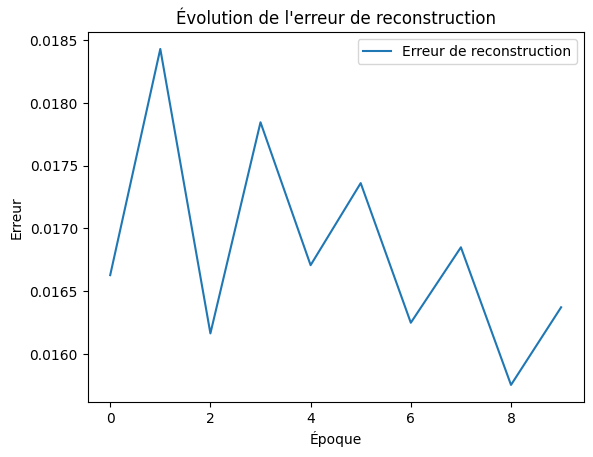

In [7]:
plot_erreur(epoch, error_score)

Batch_error: tensor([[ 1.2347, -1.8633, -0.4948,  ..., -0.5760,  1.9540, -0.0734],
        [ 1.6814, -0.9789, -0.7288,  ..., -0.7146,  1.8984, -0.3040],
        [ 1.3440, -0.4148, -0.7538,  ..., -0.2633,  1.3537, -1.0096],
        ...,
        [ 0.9680, -0.3631, -1.1739,  ..., -0.0691,  0.0468, -1.3711],
        [ 1.8653, -0.5401, -0.2990,  ..., -0.3037,  0.7326, -1.6836],
        [ 1.5925, -1.4301, -1.9916,  ..., -0.8309,  0.1197, -0.4029]],
       grad_fn=<SubBackward0>)
Batch_error: tensor([[-0.7653,  0.1367,  1.5052,  ...,  1.4240, -0.0460,  1.9266],
        [-0.3186,  1.0211,  1.2712,  ...,  1.2854, -0.1016,  1.6960],
        [-0.6560,  1.5852,  1.2462,  ...,  1.7367, -0.6463,  0.9904],
        ...,
        [-1.0320,  1.6369,  0.8261,  ...,  1.9309, -1.9532,  0.6289],
        [-0.1347,  1.4599,  1.7010,  ...,  1.6963, -1.2674,  0.3164],
        [-0.4075,  0.5699,  0.0084,  ...,  1.1691, -1.8803,  1.5971]],
       grad_fn=<SubBackward0>)
Batch_error: tensor([[-0.7653, -1.8633,  1.4

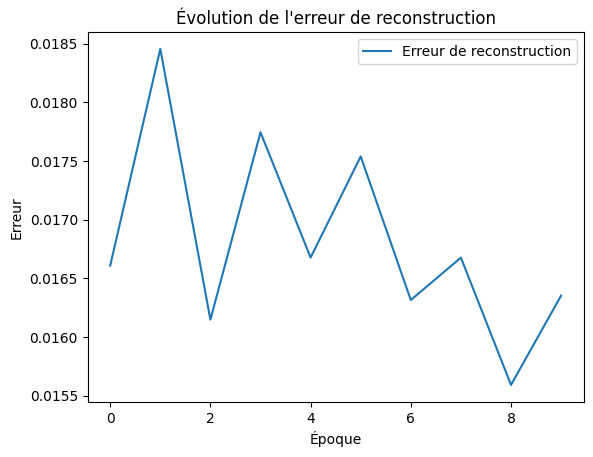

In [ ]:
epoch = 10
error_score = []
Batch_error = torch.zeros(batch_size, visible_dim)

for _ in range(epoch):
    # Applique le contraste de divergence sur le lot
    RBM_P.contrastive_divergence(Batch_data)
    
    # Effectue la propagation avant pour obtenir les prédictions
    Batch_pred = RBM_P.forward(Batch_data)
    
    # Imprimer Batch_data et Batch_pred pour vérifier s'ils diffèrent

    
    # Calcul de l'erreur
    Batch_error = Batch_data - Batch_pred
    error = 0  
    
    # Imprimer Batch_error pour voir l'écart entre les données et les prédictions
    #print(f"Batch_error: {Batch_error}")
    
    for i in range(len(Batch_error)):
        error = error + (1/visible_dim)*torch.sqrt(((Batch_error[i, :]) ** 2).sum()).item()

    error_score.append(error)  # Erreur quadratique

plot_erreur(epoch, error_score)


Alors on remarque là une parallélisation contre productive.

In [26]:
# Sauvegarder le modèle 

torch.save(RBM.state_dict(), '../models_saved/RBM_contrast_div.pth')

Comme on peut le voir le temps d'entrainement du modèle est assez élevé malgré la vactorisation du code.
Pour celà nous allons paralléliser les calculs. L'indépendances des variables conditionnelles v_i/H et h_i/V est un avantage car conditionnellement à une couche les calculs des états des neuronnes de l'autres couche sont indépendants et peuvent se paralléliser.

**Parallélisation naive avec multiprocessing** 

In [27]:
import multiprocessing

In [28]:
def test():
    print("Hello from process", multiprocessing.current_process().name)

if __name__ == "__main__":
    p = multiprocessing.Process(target=test)
    p.start()
    p.join()


Hello from process Process-1


In [ ]:
def worker(task_queue):
    while not task_queue.empty():
        task = task_queue.get()
        task()  # Exécuter la tâche

def task_1():
    print("Exécution de la tâche 1")

def task_2():
    print("Exécution de la tâche 2")

def assign_tasks():
    task_queue = multiprocessing.Queue()
    task_queue.put(task_1)
    task_queue.put(task_2)
    
    # Créer et démarrer les processus
    processes = []
    for _ in range(2):  # 2 processus
        p = multiprocessing.Process(target=worker, args=(task_queue,))
        processes.append(p)
        p.start()

    # Attendre la fin de l'exécution des processus
    for p in processes:
        p.join()

assign_tasks()


Exécution de la tâche 1Exécution de la tâche 2



Nous allons mtn faire passer toutes ces données dans la RBm à la fois et voir ce qu'on  

Voici les choses que tu devra faire aujourd'hui : 

- Commencer aussi à regarder pour la parallélisation du calcule des etats des variables indépendantes. (Est ce qu'on peut paralléliser sur un CPU ?)

- Voir comment tu peux optimiser l'apprentissage de ta RBM ; en gros dimunier le temps d'apprentissage et aussi mieux apprendre sur les données ensuite tu regardes la courbes de reconstruction chaque fois. Ici tu peux jouer sur le choix des hyperparamètres et pourquoi pas apprendre le learning rate si c'est possible.

- Commencer à voir où (les endroits) tu peux imbriquer des RBM autres que seulement entre l'encodeur et le decodeur, ou meme t'inspirer de l'article sur la classification d'image avec une RBM pour voir quelles achitectures pouraient aider à avoir encore de meilleure performances.
 